In [1]:
from golem_model_01 import GolemModel
from golem_utils.train import postprocess
from golem_utils.utils import set_seed
from golem_utils import MetricsDAG
from golem_utils import GraphDAG
from golem_utils import BaseLearner, Tensor
import logging

import igraph as ig
import networkx as nx
import numpy as np
import time
from golem_utils.utils import is_dag

In [2]:
from DAG_GOLEM.golem import GOLEM as GM

In [3]:
from datasets import DAG, IIDSimulation

/home/klea.ziu/.conda/envs/OCM/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import torch
import torch.nn as nn

In [5]:
class SyntheticDataset:
    """Generate synthetic data.

    Key instance variables:
        X (numpy.ndarray): [n, d] data matrix.
        B (numpy.ndarray): [d, d] weighted adjacency matrix of DAG.
        B_bin (numpy.ndarray): [d, d] binary adjacency matrix of DAG.

    Code modified from:
        https://github.com/xunzheng/notears/blob/master/notears/utils.py
    """
    _logger = logging.getLogger(__name__)

    def __init__(self, n, d, graph_type, degree, noise_type, B_scale,hd:bool = False, seed=1):
        """Initialize self.

        Args:
            n (int): Number of samples.
            d (int): Number of nodes.
            graph_type ('ER' or 'SF'): Type of graph.
            degree (int): Degree of graph.
            noise_type ('gaussian_ev', 'gaussian_nv', 'exponential', 'gumbel'): Type of noise.
            B_scale (float): Scaling factor for range of B.
            seed (int): Random seed. Default: 1.
        """
        self.n = n
        self.d = d
        self.graph_type = graph_type
        self.degree = degree
        self.noise_type = noise_type
        self.B_ranges = ((B_scale * -2.0, B_scale * -0.5),
                         (B_scale * 0.5, B_scale * 2.0))
        self.rs = np.random.RandomState(seed)    # Reproducibility
        self.hd = hd

        self._setup()
        self._logger.debug("Finished setting up dataset class.")

    def _setup(self):
        """Generate B_bin, B and X."""
        self.B_bin = SyntheticDataset.simulate_random_dag(self.d, self.degree,
                                                          self.graph_type, self.rs)
        self.B = SyntheticDataset.simulate_weight(self.B_bin, self.B_ranges, self.hd,self.rs)
        
        self.X = SyntheticDataset.simulate_linear_sem(self.B, self.n, self.noise_type, self.rs)
        assert is_dag(self.B)

    @staticmethod
    def simulate_er_dag(d, degree, rs=np.random.RandomState(1)):
        """Simulate ER DAG using NetworkX package.

        Args:
            d (int): Number of nodes.
            degree (int): Degree of graph.
            rs (numpy.random.RandomState): Random number generator.
                Default: np.random.RandomState(1).

        Returns:
            numpy.ndarray: [d, d] binary adjacency matrix of DAG.
        """
        def _get_acyclic_graph(B_und):
            return np.tril(B_und, k=-1)

        def _graph_to_adjmat(G):
            return nx.to_numpy_matrix(G)

        p = float(degree) / (d - 1)
        G_und = nx.generators.erdos_renyi_graph(n=d, p=p, seed=rs)
        B_und_bin = _graph_to_adjmat(G_und)    # Undirected
        B_bin = _get_acyclic_graph(B_und_bin)
        return B_bin

    @staticmethod
    def simulate_sf_dag(d, degree):
        """Simulate ER DAG using igraph package.

        Args:
            d (int): Number of nodes.
            degree (int): Degree of graph.

        Returns:
            numpy.ndarray: [d, d] binary adjacency matrix of DAG.
        """
        def _graph_to_adjmat(G):
            return np.array(G.get_adjacency().data)

        m = int(round(degree / 2))
        # igraph does not allow passing RandomState object
        G = ig.Graph.Barabasi(n=d, m=m, directed=True)
        B_bin = np.array(G.get_adjacency().data)
        return B_bin

    @staticmethod
    def simulate_random_dag(d, degree, graph_type, rs=np.random.RandomState(1)):
        """Simulate random DAG.

        Args:
            d (int): Number of nodes.
            degree (int): Degree of graph.
            graph_type ('ER' or 'SF'): Type of graph.
            rs (numpy.random.RandomState): Random number generator.
                Default: np.random.RandomState(1).

        Returns:
            numpy.ndarray: [d, d] binary adjacency matrix of DAG.
        """
        def _random_permutation(B_bin):
            # np.random.permutation permutes first axis only
            P = rs.permutation(np.eye(B_bin.shape[0]))
            return P.T @ B_bin @ P

        if graph_type == 'ER':
            B_bin = SyntheticDataset.simulate_er_dag(d, degree, rs)
        elif graph_type == 'SF':
            B_bin = SyntheticDataset.simulate_sf_dag(d, degree)
        else:
            raise ValueError("Unknown graph type.")
        return _random_permutation(B_bin)

    @staticmethod
    def simulate_weight(B_bin, B_ranges, hd, rs=np.random.RandomState(1)):
        """Simulate the weights of B_bin.

        Args:
            B_bin (numpy.ndarray): [d, d] binary adjacency matrix of DAG.
            B_ranges (tuple): Disjoint weight ranges.
            rs (numpy.random.RandomState): Random number generator.
                Default: np.random.RandomState(1).

        Returns:
            numpy.ndarray: [d, d] weighted adjacency matrix of DAG.
        """
        B = np.zeros(B_bin.shape)
        S = rs.randint(len(B_ranges), size=B.shape)  # Which range
        for i, (low, high) in enumerate(B_ranges):
            if hd == True:
                
                if np.random.rand(1) > 0.5:
                    #the same as before
                    U = rs.uniform(low=low, high=high, size=B.shape)
                else:
                    U_0 = rs.uniform(low=-3, high=-1, size=B.shape)
                    U =   rs.uniform(low=low, high=high, size=B.shape)*np.exp(U_0)
                B += B_bin * (S == i) * U
                
            else:
                U = rs.uniform(low=low, high=high, size=B.shape)
                B += B_bin * (S == i) * U
      
        return B

    @staticmethod
    def simulate_linear_sem(B, n, noise_type, rs=np.random.RandomState(1)):
        """Simulate samples from linear SEM with specified type of noise.

        Args:
            B (numpy.ndarray): [d, d] weighted adjacency matrix of DAG.
            n (int): Number of samples.
            noise_type ('gaussian_ev', 'gaussian_nv', 'exponential', 'gumbel'): Type of noise.
            rs (numpy.random.RandomState): Random number generator.
                Default: np.random.RandomState(1).

        Returns:
            numpy.ndarray: [n, d] data matrix.
        """
        def _simulate_single_equation(X, B_i):
            """Simulate samples from linear SEM for the i-th node.

            Args:
                X (numpy.ndarray): [n, number of parents] data matrix.
                B_i (numpy.ndarray): [d,] weighted vector for the i-th node.

            Returns:
                numpy.ndarray: [n,] data matrix.
            """
            if noise_type == 'gaussian_ev':
                # Gaussian noise with equal variances
                N_i = rs.normal(scale=1.0, size=n)
            elif noise_type == 'gaussian_nv':
                # Gaussian noise with non-equal variances
                scale = rs.uniform(low=1.0, high=2.0)
                N_i = rs.normal(scale=scale, size=n)
            elif noise_type == 'exponential':
                # Exponential noise
                N_i = rs.exponential(scale=1.0, size=n)
            elif noise_type == 'gumbel':
                # Gumbel noise
                N_i = rs.gumbel(scale=1.0, size=n)
            else:
                raise ValueError("Unknown noise type.")
            return X @ B_i + N_i

        d = B.shape[0]
        X = np.zeros([n, d])
        G = nx.DiGraph(B)
        ordered_vertices = list(nx.topological_sort(G))
        assert len(ordered_vertices) == d
        for i in ordered_vertices:
            parents = list(G.predecessors(i))
            X[:, i] = _simulate_single_equation(X[:, parents], B[parents, i])

        return X




In [6]:
class GOLEM(BaseLearner):
    """
    GOLEM Algorithm.
    A more efficient version of NOTEARS that can reduce number of optimization iterations.

    Paramaters
    ----------
    B_init: None
        File of weighted matrix for initialization. Set to None to disable.
    lambda_1: float
        Coefficient of L1 penalty.
    lambda_2: float
        Coefficient of DAG penalty.
    equal_variances: bool
        Assume equal noise variances for likelibood objective.
    non_equal_variances: bool
        Assume non-equal noise variances for likelibood objective.
    learning_rate: float
        Learning rate of Adam optimizer.
    num_iter: float
        Number of iterations for training.
    checkpoint_iter: int
        Number of iterations between each checkpoint. Set to None to disable.
    seed: int
        Random seed.
    graph_thres: float
        Threshold for weighted matrix.
    device_type: bool
        whether to use GPU or not
    device_ids: int
        choose which gpu to use

    Attributes
    ----------
    causal_matrix : numpy.ndarray
        Learned causal structure matrix

    References
    ----------
    https://arxiv.org/abs/2006.10201
    
    Examples
    --------
    >>> from castle.algorithms import GOLEM
    >>> from castle.datasets import load_dataset
    >>> from castle.common import GraphDAG
    >>> from castle.metrics import MetricsDAG
    >>> X, true_dag, topology_matrix = load_dataset(name='IID_Test')
    >>> n = GOLEM()
    >>> n.learn(X)
    >>> GraphDAG(n.causal_matrix, true_dag)
    >>> met = MetricsDAG(n.causal_matrix, true_dag)
    >>> print(met.metrics)
    """
    
    def __init__(self, B_init=None,
                 lambda_1=2e-2,
                 lambda_2=5.0,
                 l1 = 0.05,
                 l1_q = 0.5,
                 equal_variances=True,
                 non_equal_variances=True,
                 learning_rate=1e-3,
                 num_iter=1e+5,
                 checkpoint_iter=5000,
                 seed=1,
                 graph_thres=0.3,
                 device_type='cpu',
                 device_ids=0):

        super().__init__()

        self.B_init = B_init
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.l1 = l1
        self.l1_quad = l1_q
        self.equal_variances = equal_variances
        self.non_equal_variances = non_equal_variances
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.checkpoint_iter = checkpoint_iter
        self.seed = seed
        self.graph_thres = graph_thres
        self.device_type = device_type
        self.device_ids = device_ids

        if torch.cuda.is_available():
            print('GPU is available.')
        else:
            print('GPU is unavailable.')
            if self.device_type == 'gpu':
                raise ValueError("GPU is unavailable, "
                                 "please set device_type = 'cpu'.")
        if self.device_type == 'gpu':
            if self.device_ids:
                os.environ['CUDA_VISIBLE_DEVICES'] = str(self.device_ids)
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        self.device = device
        

    def learn(self, data, columns=None, **kwargs):
        """
        Set up and run the GOLEM algorithm.

        Parameters
        ----------
        data: castle.Tensor or numpy.ndarray
            The castle.Tensor or numpy.ndarray format data you want to learn.
        X: numpy.ndarray
            [n, d] data matrix.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        lambda_1: float
            Coefficient of L1 penalty.
        lambda_2: float
            Coefficient of DAG penalty.
        equal_variances: bool
            Whether to assume equal noise variances
            for likelibood objective. Default: True.
        num_iter:int
            Number of iterations for training.
        learning_rate: float
            Learning rate of Adam optimizer. Default: 1e-3.
        seed: int
            Random seed. Default: 1.
        checkpoint_iter: int
            Number of iterations between each checkpoint.
            Set to None to disable. Default: None.
        B_init: numpy.ndarray or None
            [d, d] weighted matrix for initialization.
            Set to None to disable. Default: None.
        """

        X = Tensor(data, columns=columns)
        
        causal_matrix = self._golem(X)
        self.causal_matrix = Tensor(causal_matrix, index=X.columns,
                                    columns=X.columns)

    def _golem(self, X):
        """
        Solve the unconstrained optimization problem of GOLEM, which involves
        GolemModel and GolemTrainer.

        Parameters
        ----------
        X: numpy.ndarray
            [n, d] data matrix.
        
        Return
        ------
        B_result: np.ndarray
            [d, d] estimated weighted matrix.
        
        Hyperparameters
        ---------------
        (1) GOLEM-NV: equal_variances=False, lambda_1=2e-3, lambda_2=5.0.
        (2) GOLEM-EV: equal_variances=True, lambda_1=2e-2, lambda_2=5.0.
        """
        set_seed(self.seed)
        n, d = X.shape
        X = torch.Tensor(X).to(self.device)

        #Set up model
        model = GolemModel(n=n, d=d, lambda_1=self.lambda_1,
                           lambda_2=self.lambda_2, l1 = self.l1, l1_quad = self.l1_quad,
                           equal_variances=self.equal_variances,
                           B_init=self.B_init,
                           device=self.device)

        self.train_op = torch.optim.Adam(model.parameters(), lr=0.001)

        print("Started training for {} iterations.".format(int(self.num_iter)))
        for i in range(0, int(self.num_iter) + 1):
            model(X)
            score, likelihood, quad, h, B_est = model.score, model.likelihood, model.quad, model.h, model.B
            
            if i > 0:  #Do not train here, only perform evaluation
                #Optimizer
                self.loss = score 
                self.train_op.zero_grad()
                self.loss.backward()
                self.train_op.step()

            #do thresholding
            if i%500 == 0 :
                model(X)
                score, likelihood, quad, h, B_est = model.score, model.likelihood, model.quad, model.h, model.B
                with torch.no_grad():
                    B_processed = postprocess(B_est.cpu().detach().numpy(), graph_thres=0.001)

                    for p in model.parameters():
                        p.zero_().add_(torch.tensor(B_processed))

                    print("[Before thresholding] score={:.3f}, likelihood={:.3f}, h={:.1e}, quad = {:.3f}".format( \
                 score, likelihood, h,quad))
                    model(X)
                    score, likelihood,quad, h, B_est = model.score, model.likelihood, model.quad, model.h, model.B
                    #print(B_est)
                    print("[Iter {}] score={:.3f}, likelihood={:.3f}, h={:.1e}, quad = {:.3f}".format( \
                        i, score, likelihood, h,quad))

        #Post-process estimated solution and compute results
        #B_processed = postprocess(B_est.cpu().detach().numpy(), graph_thres=0.3)
        
        with torch.no_grad():
            B_processed = postprocess(B_est.cpu().detach().numpy(), graph_thres=0.07)
            for p in model.parameters():
                        p.zero_().add_(torch.tensor(B_processed))
            model(X)
            score, likelihood,quad, h, B_est = model.score, model.likelihood, model.quad, model.h, model.B
            print('3',B_est)
            print("[Iter {}] score={:.3f}, likelihood={:.3f}, h={:.1e}, quad = {:.3f}".format( \
                    i, score, likelihood, h,quad))
        B_result =(B_processed != 0).astype(int)
        #B_processed = postprocess(B_est.cpu().detach().numpy(), graph_thres=0.03)
        return B_est.cpu().detach().numpy() #B_processed

In [50]:
n, d =1000, 20
graph_type, degree = 'ER', 2    # ER2 graph
B_scale = 1.0
noise_type = 'gaussian_ev'

dataset = SyntheticDataset(n, d, graph_type, degree,
                           noise_type, B_scale,hd = True, seed=1)


In [51]:
g = GOLEM(num_iter=1e4)
g1 = GM(num_iter=1e4)

GPU is available.
GPU is available.


In [52]:
true_dag, X = dataset.B, dataset.X

In [53]:
true_dag

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.96131894,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  

In [54]:
time_start = time.time()
g.learn(X)
time_end = time.time()

Started training for 10000 iterations.
[Before thresholding] score=111.400, likelihood=111.400, h=0.0e+00, quad = 1721.756
[Iter 0] score=111.400, likelihood=111.400, h=0.0e+00, quad = 1721.756
[Before thresholding] score=103.870, likelihood=102.827, h=1.1e-01, quad = 651.884
[Iter 500] score=105.621, likelihood=104.745, h=0.0e+00, quad = 886.881
[Before thresholding] score=101.677, likelihood=100.396, h=2.8e-01, quad = 527.730
[Iter 1000] score=103.498, likelihood=102.364, h=0.0e+00, quad = 699.834
[Before thresholding] score=100.817, likelihood=99.591, h=2.4e-01, quad = 480.407
[Iter 1500] score=101.997, likelihood=100.891, h=0.0e+00, quad = 604.361
[Before thresholding] score=100.405, likelihood=99.263, h=1.2e-01, quad = 467.745
[Iter 2000] score=101.100, likelihood=100.046, h=0.0e+00, quad = 555.464
[Before thresholding] score=100.215, likelihood=99.137, h=4.9e-02, quad = 471.685
[Iter 2500] score=100.593, likelihood=99.579, h=0.0e+00, quad = 530.302
[Before thresholding] score=100

In [55]:
t_start = time.time()
g1.learn(X)
t_end = time.time()

Started training for 10000 iterations.
[Iter 0] score=111.400, likelihood=111.400, h=0.0e+00
[Iter 5000] score=99.457, likelihood=99.003, h=5.5e-04
[Iter 10000] score=99.457, likelihood=99.003, h=5.5e-04
3 tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.9265,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        

In [56]:
t_end - t_start, time_end - time_start

(18.52911400794983, 15.55009150505066)

In [59]:
met = MetricsDAG((g.causal_matrix!=0).astype(int), (true_dag!=0).astype(int))
print(met.metrics)

{'fdr': 0.0, 'tpr': 0.8519, 'fpr': 0.0, 'shd': 4, 'nnz': 23, 'precision': 1.0, 'recall': 0.8519, 'F1': 0.92, 'gscore': 0.8519}


In [60]:
met = MetricsDAG((g1.causal_matrix!=0).astype(int), (true_dag!=0).astype(int))
print(met.metrics)

{'fdr': 0.0, 'tpr': 0.5926, 'fpr': 0.0, 'shd': 11, 'nnz': 16, 'precision': 1.0, 'recall': 0.5926, 'F1': 0.7442, 'gscore': 0.5926}


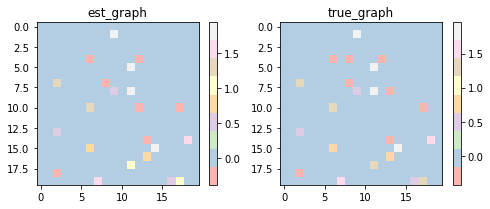

In [61]:
GraphDAG(g.causal_matrix, true_dag)

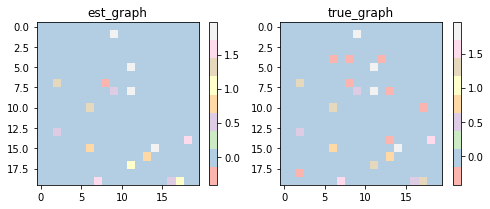

In [62]:
GraphDAG(g1.causal_matrix, true_dag)

In [46]:
d_e2 = [10,50,80,120]
shd_ours2 = [3,17,21,34]
shd_golem2 = [6,33,32,63]
tpr_ours2 = [0.7857,0.7333,0.7907,0.7634]
tpr_golem2 = [0.5714, 0.45,0.6279,0.5191]
fpr_ours2 = []
fpr_golem2 = []
t_ours2 = [ 8.57,22.24,38.65,83.02]
t_golem2 = [10.08,28.15,34.59,45.98]


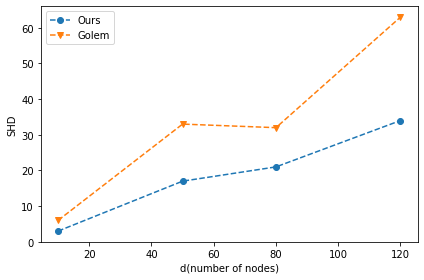

In [47]:
import matplotlib.pyplot as plt

plt.plot(d_e2,shd_ours2,'o--',label = 'Ours')
plt.plot(d_e2, shd_golem2,"v--", label = 'Golem')
plt.ylabel("SHD")
plt.xlabel('d(number of nodes)')

plt.legend()
plt.tight_layout()
plt.savefig("img/gauss_er2.pdf")
plt.show()

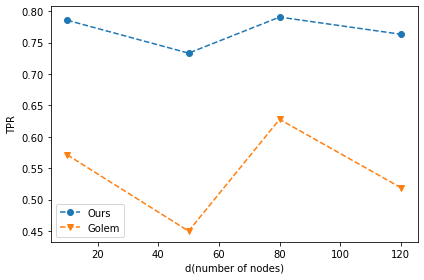

In [48]:
plt.plot(d_e2,tpr_ours2,'o--',label = 'Ours')
plt.plot(d_e2, tpr_golem2,"v--", label = 'Golem')
plt.ylabel("TPR")
plt.xlabel('d(number of nodes)')
plt.legend()
plt.tight_layout()
plt.savefig("img/gauss_er2_tpr.pdf")
plt.show()

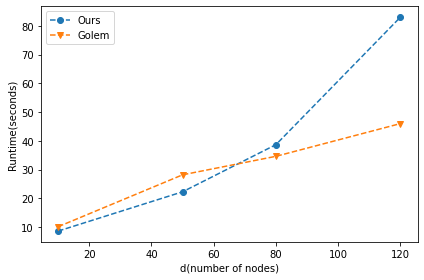

In [49]:
plt.plot(d_e2,t_ours2,'o--',label = 'Ours')
plt.plot(d_e2, t_golem2,"v--", label = 'Golem')
plt.ylabel("Runtime(seconds)")
plt.xlabel('d(number of nodes)')
plt.legend()
plt.tight_layout()
plt.savefig("img/gauss_er2_t.pdf")
plt.show()

# ER4

In [258]:
d_e = [10,20,30,50,70,100,150]
shd_ours = [12,24,23,52,62,76,72]
shd_golem = [19,22,31,52,57,93,119]
tpr_ours = [0.5,0.8039,0.7879,0.8288,0.7329,0.7256,0.7803]
tpr_golem = [0.208,0.5686, 0.5303,0.5315, 0.6096,0.5674,0.6098]
fpr_ours = [0.2381,0.1367,0.0298, 0.0323,0.0132,0.0049,0.0009]
fpr_golem= [0.0,0.0,0.0,0.0]
t_ours = [ 8.679,17.276,20.617,26.637,41.579,126.101,720.680]
t_golem = [10.126,19.414,24.079,34.707,42.643,45.231,563.69]
norm_ours = [0.6327,2.474,2.1233]
norm_golem = [0.7609,1.3405,1.2580]

In [289]:
d_e = [10,20,30,50, 70,100,150]
shd_ours_sf = [4,10,15,18,34, 66,125]
shd_golem_sf = [8,10,29,33,39,89,243]
tpr_ours_sf = [0.7647,0.8378,0.7368,0.8351,0.9051,0.8071,0.5892]
tpr_golem_sf = [ 0.5294,0.7297,0.4912,0.6598,0.7153, 0.5533,0.1818]
fpr_ours_sf = [0.1071,0.0327, 0.0026,0.0018, 0.0097,0.0063,0.0013]
fpr_golem_sf = [0.0,0.0,0.0,0.0,0.0006,0.0,0.0]
t_ours_sf = [ 9.237,17.949,20.429,25.604,71.883,134.664,390.54]
t_golem_sf = [10.901,20.49,24.074,31.165, 76.857,108.124,873.208]

In [315]:
d_exp = [10,20,30,50, 70,100,150]
shd_ours_exp = [9,31,33,52,79,86,88]
shd_golem_exp= [9,26,32,54,59,96,119]
tpr_ours_exp = [0.75,0.6275,0.6061,0.7297,0.7603,0.7256,0.777]
tpr_golem_exp = [0.625,0.5098,0.5152,0.5135,0.5959,0.5535,0.6098]
fpr_ours_exp = [ 0.1429,0.1295,0.0298,0.0242,0.0238,0.0078,0.0027]
fpr_golem_exp= [0.0,0.0072,0.0,0.0,0.0004,0.0002,0.0002]
t_ours_exp = [10.51,17.292,21.12,28.98,51.39,88.60,572.89]
t_golem_exp = [12.23,19.78,22.76,34.41,36.50,47.88,448.01]


In [316]:
d_exp = [10,20,30,50, 70,100,150]
shd_ours_exp_sf = [19,16,23,25,32,78,82]
shd_golem_exp_sf= [12,12,29,34,39,88,125]
tpr_ours_exp_sf= [0.5294,0.7838,0.6491,0.7938,0.8905,0.7919,0.8013]
tpr_golem_exp_sf = [0.3529,0.6757,0.4912,0.6495,0.7153,0.5533,0.5791]
fpr_ours_exp_sf = [0.4286,0.0654,0.0185,0.0062,0.0075,0.0082,0.0034]
fpr_golem_exp_sf = [0.0357,0.0,0.0,0.0,0.0,0.0, 0.0004]
t_ours_exp_sf = [10.440,17.83,20.67,29.13,41.80,76.76,484.07]
t_golem_exp_sf = [12.24,19.63,23.92,31.21,36.28,45.03,344.37]


In [317]:
d_e = [10,20,30,50, 70,100,150]
shd_ours_gl = [7,31,26,50,73,69,79]
shd_golem_gl = [9,26,28,54,57,97,119]
tpr_ours_gl = [0.708,0.6667,0.6515,0.7117,0.7397,0.7256,0.777]
tpr_golem_gl = [  0.625,0.5098,0.5758,0.5135,0.6096,0.5488,0.6098]
fpr_ours_gl = [0.0,0.1439,0.0136,0.0215,0.0203, 0.003, 0.0018]
fpr_golem_gl = [0.0,0.0072,0.0, 0.0009,0.0,0.0002,0.0]
t_ours_gl = [8.95,17.31,20.91,28.51,45.59,82.79,474.05]
t_golem_gl = [10.58,19.54,22.07,32.46,36.81,46.582,315.88]


In [318]:
d_e = [10,20,30,50, 70,100,150]
shd_ours_gl_sf = [8,11,18,19,18,64,55]
shd_golem_gl_sf = [9,13,29,34,41,88,121]
tpr_ours_gl_sf = [0.6471,0.8108,0.7018,0.8351,0.9051,0.8173,0.8249]
tpr_golem_gl_sf = [0.4706,  0.6486,0.4912,0.6495,0.7007,0.5533,0.596]
fpr_ours_gl_sf = [0.1071,0.0392,0.0053,0.0027,0.0022, 0.0065, 0.0006]
fpr_golem_gl_sf = [0.0,0.0,0.0,0.0,0.0004,0.0002,0.0006]
t_ours_gl_sf = [9.24,17.78,20.19,26.97,39.46,74.50,456]
t_golem_gl_sf = [10.62,19.85,22.54,32.33,39.73,50.70,361.8]




In [320]:
(np.array(shd_ours_sf) + np.array(shd_ours)+ np.array(shd_ours_exp)+ np.array(shd_ours_exp_sf)+ np.array(shd_ours_gl)+ np.array(shd_ours_gl_sf))/6

array([ 9.83333333, 20.5       , 23.        , 36.        , 49.66666667,
       73.16666667, 83.5       ])

In [321]:
(np.array(tpr_ours_sf) + np.array(tpr_ours)+ np.array(tpr_ours_exp)+ np.array(tpr_ours_exp_sf)+ np.array(tpr_ours_gl)+ np.array(tpr_ours_gl_sf))/6

array([0.64986667, 0.75508333, 0.68886667, 0.78903333, 0.82226667,
       0.76551667, 0.75828333])

In [322]:
(np.array(t_ours_sf) + np.array(t_ours)+ np.array(t_ours_exp)+ np.array(t_ours_exp_sf)+ np.array(t_ours_gl)+ np.array(t_ours_gl_sf))/6

array([  9.50933333,  17.57283333,  20.656     ,  27.6385    ,
        48.617     ,  97.23583333, 516.37166667])

In [323]:
(np.array(t_golem_sf) + np.array(t_golem)+ np.array(t_golem_exp)+ np.array(t_golem_exp_sf)+ np.array(t_golem_gl)+ np.array(t_golem_gl_sf))/6

array([ 11.11616667,  19.784     ,  23.2405    ,  32.71366667,
        44.80333333,  57.25783333, 484.493     ])

In [324]:
(np.array(tpr_golem_sf) + np.array(tpr_golem)+ np.array(tpr_golem_exp)+ np.array(tpr_golem_exp_sf)+ np.array(tpr_golem_gl)+ np.array(tpr_golem_gl_sf))/6

array([0.46848333, 0.60703333, 0.51581667, 0.58621667, 0.65773333,
       0.55493333, 0.53105   ])

In [325]:
(np.array(shd_golem_sf) + np.array(shd_golem)+ np.array(shd_golem_exp)+ np.array(shd_golem_exp_sf)+ np.array(shd_golem_gl)+ np.array(shd_golem_gl_sf))/6

array([ 11.        ,  18.16666667,  29.66666667,  43.5       ,
        48.66666667,  91.83333333, 141.        ])

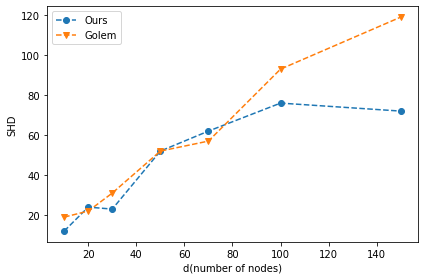

In [307]:
import matplotlib.pyplot as plt
#title = plt.title('ER4')
plt.plot(d_e,shd_ours,'o--',label = 'Ours')
plt.plot(d_e, shd_golem,"v--", label = 'Golem')
plt.ylabel("SHD")
plt.xlabel('d(number of nodes)')

plt.legend()
plt.tight_layout()
plt.savefig("img/gauss_er.pdf")
plt.show()

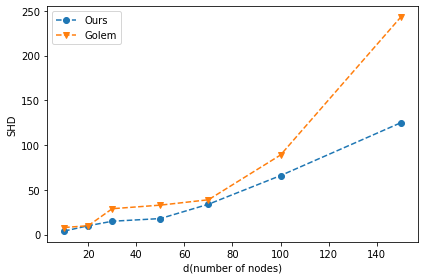

In [308]:
plt.plot(d_e,shd_ours_sf,'o--',label = 'Ours')
plt.plot(d_e, shd_golem_sf,"v--", label = 'Golem')
plt.ylabel("SHD")
plt.xlabel('d(number of nodes)')
plt.legend()
plt.tight_layout()
plt.savefig("img/gauss_sf.pdf")
plt.show()

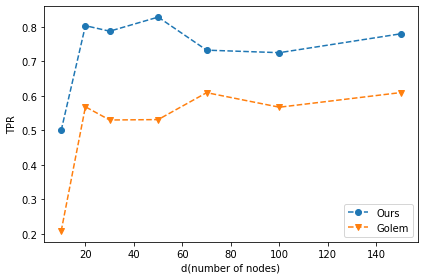

In [309]:
plt.plot(d_e,tpr_ours,'o--',label = 'Ours')
plt.plot(d_e, tpr_golem,"v--", label = 'Golem')
plt.ylabel("TPR")
plt.xlabel('d(number of nodes)')
plt.legend()
plt.tight_layout()
plt.savefig("img/gauss_er_tpr.pdf")
plt.show()

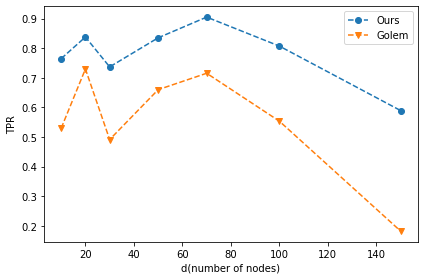

In [310]:
plt.plot(d_e,tpr_ours_sf,'o--',label = 'Ours')
plt.plot(d_e, tpr_golem_sf,"v--", label = 'Golem')
plt.ylabel("TPR")
plt.xlabel('d(number of nodes)')
plt.legend()
plt.tight_layout()
plt.savefig("img/gauss_sf_tpr.pdf")
plt.show()

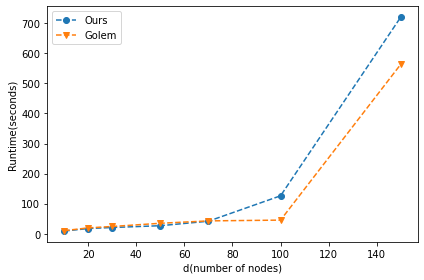

In [311]:
plt.plot(d_e,t_ours,'o--',label = 'Ours')
plt.plot(d_e, t_golem,"v--", label = 'Golem')
plt.ylabel("Runtime(seconds)")
plt.xlabel('d(number of nodes)')
plt.legend()
plt.tight_layout()
plt.savefig("img/gauss_er_t.pdf")
plt.show()

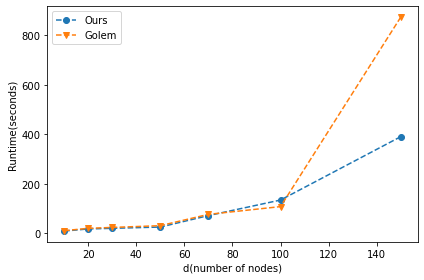

In [312]:
plt.plot(d_e,t_ours_sf,'o--',label = 'Ours')
plt.plot(d_e, t_golem_sf,"v--", label = 'Golem')
plt.ylabel("Runtime(seconds)")
plt.xlabel('d(number of nodes)')
plt.legend()
plt.tight_layout()
plt.savefig("img/gauss_sf_t.pdf")
plt.show()